### Imports for this Notebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from scipy.sparse import hstack
from sklearn.neural_network import MLPClassifier, BernoulliRBM

C:\Users\sharm\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Read data

In [2]:
# Read the data

# path to the train data file
INDATA_LOCATION = 'C:/Users/sharm/Desktop/Dat5Melb/Final_Project/train/train.csv'

# utility definitions for easier handling of the dataset column names
TEXT_COLUMN = 'comment_text'
CLASS_TOXIC, CLASS_SEVER_TOXIC, CLASS_OBSCENE, CLASS_THREAT, CLASS_INSULT, \
    CLASS_IDENTITY_HATE = ["toxic", "severe_toxic", "obscene", "threat", \
                           "insult", "identity_hate"]
CLASSES = [CLASS_TOXIC, CLASS_SEVER_TOXIC, CLASS_OBSCENE, CLASS_THREAT, CLASS_INSULT, CLASS_IDENTITY_HATE]

def read_data(filename):
    return pd.read_csv(filename) 

# read the comments and associated classification data 
dataDf = read_data(INDATA_LOCATION)

dataDf.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Basic data characteristics

In [3]:
def basic_characteristics(df):
    print('Number of data points: %d' %len(df))
    for klass in CLASSES:
        print('Number data points of type %s: %d' %(klass, len(df[df[klass]==1])))        
basic_characteristics(dataDf)

Number of data points: 159571
Number data points of type toxic: 15294
Number data points of type severe_toxic: 1595
Number data points of type obscene: 8449
Number data points of type threat: 478
Number data points of type insult: 7877
Number data points of type identity_hate: 1405


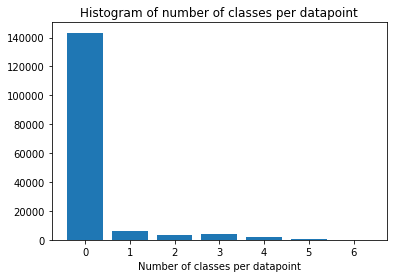

In [4]:
labels, counts = np.unique(dataDf[CLASSES].sum(axis=1), return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_title('Histogram of number of classes per datapoint')
plt.gca().set_xlabel('Number of classes per datapoint')
plt.gca().set_xticks(labels)
plt.show()

### Embed text in vector space

Using a simple count based vectorizer to embed the comment text into vector space in preparation for building classification models.

In [5]:
# create a class for vectorizing and embedding operations
class CommentVectorizer:
    
    # conventional instance method reference to parent instance and define a list object
    def __init__(self):
        # create a list object (self._) which is visible to all other methods inside the class
        # (will remian alive till the instance of the class is destroyed)
        self._vectorizers = []
    
    # initialise paramterised vectoriser count function
    def get_count_vectorizer(self, max_features = 1000, ngram_range = (1, 2), 
                             stop_words = 'english', binary = True):
        """
        Initializes a count vectorizer with parameters set by the user and 
        returns an index in the internal vector array where the vectorizer
        has been placed. We dont want any external entity manipulating the
        vectorizer state directly.
        """
        # append the input parameters to vectoriser list object instantiated above
        self._vectorizers.append(CountVectorizer(max_features = max_features, 
                                                 ngram_range = ngram_range, 
                                                 stop_words = stop_words,
                                                 binary = binary))
        
        # pass the count of objects in the list to the function. subtract 1 to align index as python inidces start from 0.
        return len(self._vectorizers) - 1
    
    
    def _exists(self, vectorizer):
        """
        Checks if the vectorizer index provided points to a valid vectorizer.
        """
        if vectorizer < 0 or len(self._vectorizers) <= vectorizer:
            raise Exception('Vectorizer index out of bound.')
            
        if self._vectorizers[vectorizer] == None:
            raise Exception('Vectorizer not initialized.')
            
        pass
    
    def fit(self, comments = [], vectorizer = -1):
        self._exists(vectorizer)
        self._vectorizers[vectorizer].fit(comments)
        
    def transform(self, comments, vectorizer):
        self._exists(vectorizer)
        return self._vectorizers[vectorizer].transform(comments)

In [6]:
# initialize a count vectorizer for this experiment    
commentVectorizer = CommentVectorizer()
vectorizer = commentVectorizer.get_count_vectorizer()
commentVectorizer.fit(dataDf[TEXT_COLUMN], vectorizer)

# embed comments into vector space
commentVectors = commentVectorizer.transform(dataDf[TEXT_COLUMN], vectorizer)

Text(0.5,1,u'Scatter plot of the comment vectors (reduced)')

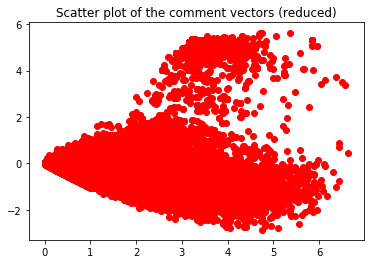

In [7]:
# fit LSI (Latent Semantic Indexing) model to commentVectors
# and generate projections of commentVectors in a 2-d space 
# using 2 components (linear combinations of words).

coords = TruncatedSVD(n_components=2).fit_transform(commentVectors)
plt.scatter(coords[:,0], coords[:,1], color ='red')
plt.title('Scatter plot of the comment vectors (reduced)')

### Create modeling and evaluation sets

In [8]:
# shuffle and split the dataset stratified by the number of classifications of a data point
# for balancing across resulting modeling and evaluation datasets

# instantiate StratifiedShuffleSplit for a single split iteration with a test dataset size of ~ 10% of population 
# and train dataset size of ~ 90% of the population and a random number generator seed of 0
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

# for balancing across resulting modeling and evaluation datasets, the y split parameter 
# generates a row sum for each data point which is used for the train vs test stratification
for train_index, test_index in sss.split(np.zeros(len(dataDf)), dataDf[CLASSES].sum(axis=1)):
    pass

# modeling dataset
""" build modeling vectors sparse matrix based on train indices """
modeling_vectors = commentVectors[train_index]
""" build modeling classes dataset by pointing to train indices """
modeling_classes = dataDf[CLASSES].loc[train_index]
print('Modeling data size: %d' %len(modeling_classes))
basic_characteristics(modeling_classes)

# evaluation dataset
""" build evalutation vectors sparse matrix based on test indices """
evaluation_vectors = commentVectors[test_index]
""" build evaluation classes dataset by pointing to test indices """
evaluation_classes = dataDf[CLASSES].loc[test_index]
print('Evaluation data size: %d' %len(evaluation_classes))
basic_characteristics(evaluation_classes)

Modeling data size: 143613
Number of data points: 143613
Number data points of type toxic: 13757
Number data points of type severe_toxic: 1442
Number data points of type obscene: 7593
Number data points of type threat: 435
Number data points of type insult: 7105
Number data points of type identity_hate: 1254
Evaluation data size: 15958
Number of data points: 15958
Number data points of type toxic: 1537
Number data points of type severe_toxic: 153
Number data points of type obscene: 856
Number data points of type threat: 43
Number data points of type insult: 772
Number data points of type identity_hate: 151


### Build Level 1 Classifier on Modeling Dataset

In [13]:
# instantiate a RandomForestClassifier
model = RandomForestClassifier(n_estimators = 20)

# set the dependent variable and perform ROC-AUC cross-validation for each of the 6 classes
for a in CLASSES: 
    print ('||class {}||'.format(a))
    y = modeling_classes[a]
    scores = cross_val_score(model, modeling_vectors, y, scoring='roc_auc')
    print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

||class toxic||
CV AUC [ 0.85459147  0.85986251  0.86178765], Average AUC 0.858747213017
||class severe_toxic||
CV AUC [ 0.89390193  0.91991876  0.90081093], Average AUC 0.904877209364
||class obscene||
CV AUC [ 0.88727239  0.89570084  0.9064027 ], Average AUC 0.896458641561
||class threat||
CV AUC [ 0.71964194  0.7829516   0.79531297], Average AUC 0.765968837439
||class insult||
CV AUC [ 0.87532001  0.8673431   0.88074674], Average AUC 0.874469951051
||class identity_hate||
CV AUC [ 0.79307617  0.81821754  0.81372609], Average AUC 0.80833993014


### Predict Individual Class Probabilities

In [15]:
# predict individual class probabilities and store them in dataframe

dfproba = pd.DataFrame(0, index=np.arange(len(modeling_classes)), columns=['dummy'])

for a in CLASSES:    
    y = modeling_classes[a]
    model.fit(modeling_vectors, y)
    proba = model.predict_proba(modeling_vectors)
    dfproba = hstack((dfproba,pd.DataFrame(data=proba)))

In [16]:
dfproba1 = dfproba.toarray()
dfproba2 = pd.DataFrame(data=dfproba1)
dfproba2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,1.000000,0.000000,1.000000,0.000000,0.950000,0.050000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,0.0,0.000000,1.000000,0.725000,0.275000,0.000000,1.000000,0.950000,0.050000,0.883333,0.116667,0.950000,0.050000
2,0.0,0.911667,0.088333,1.000000,0.000000,0.937500,0.062500,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
3,0.0,0.874747,0.125253,0.979464,0.020536,0.965705,0.034295,0.982726,0.017274,0.960139,0.039861,0.982441,0.017559
4,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000


### <font color='purple'>Placeholder for further analysis and building Level 2 Classification Model</font>

In [11]:
# import a classifier that can handle multiple classifiers and 
# performs intermediate transforms and fit being implemented by the final estimator
from sklearn.pipeline import Pipeline

# import a classifier that can perform multi-target classification
from sklearn.multioutput import MultiOutputClassifier

# define a class for classification operations
class ExtendedMultiOutputClassifier(MultiOutputClassifier):
    
    
    def transform(self, X):
        """
        Add a transform method to the classifier because it is mandatory for steps of a pipeline
        to provide fit and transform methods.
        """
        _o = self.predict_proba(X)
        return np.concatenate(_o, axis=1)

# specify the order in which pipeline should execute the classifiers/estimators    

moc = ExtendedMultiOutputClassifier(RandomForestClassifier(n_estimators = 20, class_weight = 'balanced'))

nnc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

# specify the order in which pipeline should execute the classifiers/estimators
clf = Pipeline([('moc_rf', moc), ('nnc', nnc)])

# fit all the transforms one after the other and transform the data, then fit the transformed data using the final estimator.
clf.fit(modeling_vectors, modeling_classes)

# rudimentary test 

"""
apply transforms, and predict_proba of the final estimator
"""
predictions = clf.predict_proba(modeling_vectors)

# calculate MSE (mean squared error). note np.dot on full matrix gives 
# memmory error hence the slow work around
"""
calculate the individual differences between predicted classes and modeling classes
"""
d = predictions - modeling_classes
"""
convert the prediction differences into an MSE score 
"""
sq_difs = map(lambda x: np.dot(x, x.T), d.as_matrix())
print('MSE: %f' %(np.sum(sq_difs) * 1.0 / len(d)))

MSE: 0.050813


### Evaluation

In [12]:
predictions = clf.predict_proba(evaluation_vectors)

# MSE
d = predictions - evaluation_classes
sq_difs = map(lambda x: np.dot(x, x.T), d.as_matrix())
print('MSE: %f' %(np.sum(sq_difs) * 1.0 / len(d)))

MSE: 0.157229


### <font color='green'>SCRATCHPAD</font>

In [ ]:
# dfproba3 = dfproba2.copy()
# dfproba3.columns = ['dummy','a','b','c','d','e','f','g','h','i','j','k','l']
# dfproba3.dummy.unique()
# dfproba3.shape

# y = modeling_classes[CLASS_TOXIC]
# model.fit(modeling_vectors, y)
# proba = model.predict_proba(modeling_vectors)

# dftodel = pd.DataFrame(data=proba)
# dftodel.head()


# test=pd.DataFrame(data=sq_difs)
# writer = pd.ExcelWriter('output.xlsx')
# test.to_excel(writer,'Sheet1')
# writer.save()

In [ ]:
# print feature importance
# for a in CLASSES: 
#     print ('||class {}||'.format(a))
#     y = modeling_classes[a]
#     model.fit(modeling_vectors, y)
#     all_feature_names = vectorizer.get_feature_names()
#     feature_importances = pd.DataFrame({'Features' : all_feature_names, 'Importance Score': model.feature_importances_})
#     feature_importances.sort_values('Importance Score', ascending=False).head(10)

In [ ]:
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# SIA = SentimentIntensityAnalyzer()
# df.SIA_pos = df.description.map(lambda x: SIA.polarity_scores(x)['pos'])
# df.SIA_int = df.description.map(lambda x: SIA.polarity_scores(x)['compound'])
# the output is of 4 values, e.g. ['pos'] takes the positivity component of it